# Proceso de aumentacion de respuestas al impulso 
Herramientas para analizar la distribucion en TR y DRR de los impulsos existentes, y aumentacion de estos para conformar una base de datos mas homogenea en estos descriptores. 

Dado un impulso, primero se aplican las transformaciones temporales, luego todas las de amplitud. El JND del tiempo de reverberacion es 0.2*TR lo que da un total de 118 TRs para el rango [0.1 , 1]

### POR HACER: 
    
    -VER QUE PASA EN LA CONCATENACION FINAL QUE HAGO CUANDO CAMBIO EL TIEMPO DE REVERBERACION. TENGO QUE TENER CUIDADO DE NO ESTAR METIENDO DISTROSION AHI.
    
    -HACER UNA FUNCION PROPIA QUE CALCULE EL TR PARA PODER TRABAJAR TODO CON ARRAYS Y NO CON PATHS

In [1]:
import tqdm
import acoustics
import librosa
import numpy as np 
import matplotlib.pyplot as plt 
import soundfile as sf
from tr_augmentation import tr_augmentation, get_audio_list
from drr_augmentation import *

rir_path = '/mnt/datasets/impulsos/reales/C4DM'
rir_list = get_audio_list(rir_path)

# Base de datos de entrada

In [2]:
def impulse_info(path):
    """Calcula el TRmid (promedio entre bandas de 500 y 1000 Hz) y la relacion
    directo reverberado para una respuesta al impulso 
    """
    #Tiempo de reverberacion
    bandas = acoustics.bands.octave(500,1000)
    tr_mid = acoustics.room.t60_impulse(path, bandas).mean()

    #Relacion directo-reverberado
    rir, fs = librosa.load(path, sr=16000)
    DRR, _, _ = get_DRR(rir, fs)
    return tr_mid, DRR

"""
tr_list=[]
drr_list=[]
for impulso in tqdm.tqdm(rir_list):
    tr, drr = impulse_info(impulso)
    tr_list.append(tr)
    drr_list.append(drr)    
plt.figure(1, figsize = (10,8))
plt.scatter(tr_list, drr_list, alpha = 0.7, marker = 'o')
plt.title('Respuestas al impulso reales', fontsize=18)
plt.xlabel("TR mid", fontsize=18)
plt.ylabel("DRR", fontsize=18)
plt.show()
"""

'\ntr_list=[]\ndrr_list=[]\nfor impulso in tqdm.tqdm(rir_list):\n    tr, drr = impulse_info(impulso)\n    tr_list.append(tr)\n    drr_list.append(drr)    \nplt.figure(1, figsize = (10,8))\nplt.scatter(tr_list, drr_list, alpha = 0.7, marker = \'o\')\nplt.title(\'Respuestas al impulso reales\', fontsize=18)\nplt.xlabel("TR mid", fontsize=18)\nplt.ylabel("DRR", fontsize=18)\nplt.show()\n'

# Aumentacion

In [7]:
a = 0.12313132
np.round(a,2)

0.12

In [8]:
#TRs a generar 
rir_original, fs = librosa.load(rir_list[0], sr=16000)
TR_MIN = 0.1
TR_MAX = 1.0
TR_PASO = 0.4#0.04
trs = []
tr = TR_MIN
while tr < TR_MAX:
    trs.append(np.round(tr,2))
    tr = tr * (1.0+TR_PASO)

#DRRs a generar
DRR_MIN = -3.0
DRR_MAX = 10
DRR_PASO = 1.0
drrs = []
drr = DRR_MIN
while drr < DRR_MAX:
    drrs.append(drr)
    drr = drr + DRR_PASO


#bloque de aumentacion 
for tr_deseado in tqdm.tqdm(trs):
    rir_aug_tr, fs = tr_augmentation(rir_original, fs, tr_deseado)
    for drr_deseado in drrs:
        rir_aug_drr = drr_aug(rir_aug_tr, fs, drr_deseado)
        file_name = 'aumentados/'+str(drr_deseado)+'-'+str(tr_deseado)+'.wav'
        sf.write(file_name, rir_aug_drr, fs)


100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


  0%|          | 0/91 [00:00<?, ?it/s]/home/martin/anaconda3/envs/tf/lib/python3.7/site-packages/acoustics/room.py:203: RuntimeWarning: divide by zero encountered in log10
  sch_db = 10.0 * np.log10(sch / np.max(sch))
100%|██████████| 91/91 [00:01<00:00, 77.20it/s]


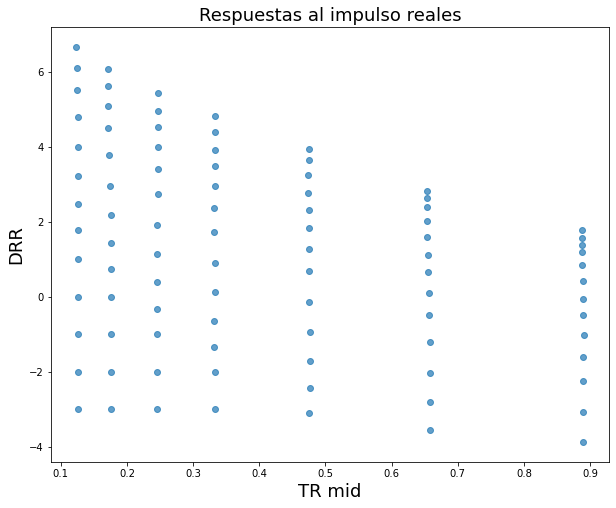

In [31]:
rir_path = '/home/martin/Documents/tesis/src/aumentacion/aumentados'
rir_list = get_audio_list(rir_path, ('.wav'))

tr_list=[]
drr_list=[]
for impulso in tqdm.tqdm(rir_list):
    tr, drr = impulse_info(impulso)
    tr_list.append(tr)
    drr_list.append(drr)    
plt.figure(1, figsize = (10,8))
plt.scatter(tr_list, drr_list, alpha = 0.7, marker = 'o')
plt.title('Respuestas al impulso reales', fontsize=18)
plt.xlabel("TR mid", fontsize=18)
plt.ylabel("DRR", fontsize=18)
plt.show()

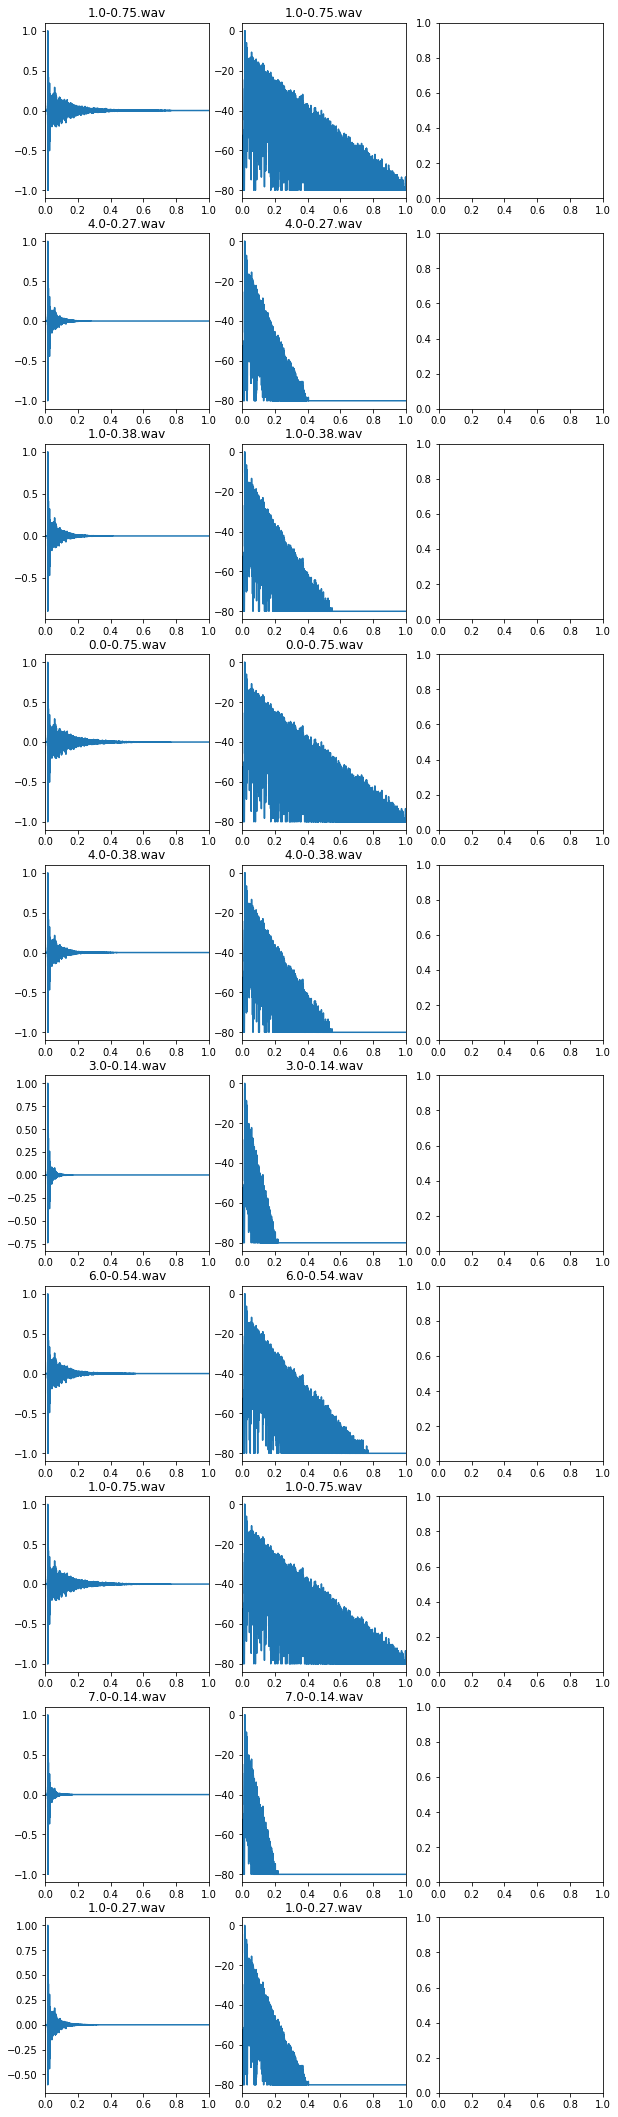

In [35]:
#ploteo algunos impulsos 
rirs_array = []
for path in rir_list:
    rir, fs = librosa.load(path, sr=16000)
    rirs_array.append(rir)

fig, axes = plt.subplots(10,3,figsize=(10,10))
t = np.linspace(0, len(rirs_array[0])/fs, len(rirs_array[0]))

for i, j in enumerate(np.random.randint(0,len(rir_list)-1,size=(10,))):
    axes[i,0].set_title(str(rir_list[j])[-12:])
    axes[i,0].plot(t,rirs_array[j])
    axes[i,0].set_xlim(0,1)
    
    axes[i,1].set_title(str(rir_list[j])[-12:])
    axes[i,1].plot(t,librosa.amplitude_to_db(rirs_array[j]))
    axes[i,1].set_xlim(0,1)
    #plot_tr(rir_list[j], axes[i, 2])

plt.subplots_adjust(top=3)

In [33]:
def plot_tr(path, ax):
    bandas = acoustics.bands.octave(125, 4000)
    tr = acoustics.room.t60_impulse(path, bandas)
    ticks_labels = [str(int(i))+' Hz' for i in bandas]
    
    ax.plot(tr, label = 'Original', linewidth = 3)
    
    #ax.set_xticks([0,1,2,3,4,5], ticks_labels, size=18)
    #ax.legend(prop={'size': 18})
    #ax.grid()
    ax.set_ylim(0,1)

In [ ]:
sf.write('rir_aug.wav', rir_aug, 16000)
#tiempo de reverb
bandas = acoustics.bands.octave(125, 4000)
tr = acoustics.room.t60_impulse(path, bandas)
tr2 = acoustics.room.t60_impulse('rir_aug.wav', bandas)

ticks_labels = [str(int(i))+' Hz' for i in bandas]
plt.plot(tr, label = 'Original', linewidth = 3)
plt.plot(tr2, label='aug', linewidth = 3)
plt.xticks([0,1,2,3,4,5], ticks_labels, size=18)
plt.legend(prop={'size': 18})
plt.grid()
plt.ylim(0,8)
print(path.split('/')[-3]+'  '+path.split('/')[-1])
plt.subplots_adjust(right=2, top=1.5, left=0)